# Dimension Reduction through Ensemble Methods




## 0. Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import re

import warnings
warnings.filterwarnings(action='ignore')

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

seed = 1234
set_seed(seed)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로를 직접 설정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Hugging Face의 병렬 처리가 비활성화
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
# max_len 도출
from typing import List

def calculate_optimal_max_len(lengths: List[int], thresholds=[64, 128, 256, 512], percentile=90) -> int:
    """
    Calculates the optimal max_len based on the specified percentile of the lengths.
    
    Args:
        lengths (List[int]): List of lengths of each text sample.
        thresholds (List[int]): Possible threshold values to choose from.
        percentile (int): The percentile to use as the cutoff for length.

    Returns:
        int: The optimal max_len based on the given percentile.
    """
    # Calculate the length at the specified percentile
    max_len_suggestion = np.percentile(lengths, percentile)
    
    # Find the closest threshold
    optimal_max_len = min(thresholds, key=lambda x: abs(x - max_len_suggestion))
    
    # Plot length distribution and percentile line
    plt.hist(lengths, bins=30, alpha=0.6, color='b', edgecolor='black')
    plt.axvline(max_len_suggestion, color='red', linestyle='--', label=f'{percentile}th percentile = {int(max_len_suggestion)}')
    plt.axvline(optimal_max_len, color='green', linestyle='-', label=f'Chosen max_len = {optimal_max_len}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution with Optimal max_len')
    plt.legend()
    plt.show()
    
    return optimal_max_len

In [7]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity_distance(vector1, vector2, label1="Vector1", label2="Vector2"):

    # 코사인 유사도 및 유클리디안 거리 계산
    similarity_block = cosine_similarity(vector1, vector2)
    euc_distances = euclidean_distances(vector1, vector2)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    # 코사인 유사도 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity_block, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity")
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    # 유클리디안 거리 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(euc_distances, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Euclidean Distance")
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    plt.tight_layout()
    plt.show()


## 1. Load Data

### Law domain data

In [10]:
law_train = pd.read_csv('../dataset_law/data/train_data.csv')
law_valid = pd.read_csv('../dataset_law/data/val_data.csv')
law_test = pd.read_csv('../dataset_law/data/test_data.csv')

In [11]:
law_train

,class,text
0,i,2) 또한 자동차 열쇠에 대한 배타적인 점유를 취득하는 이상 인근에 주차된 해당 자...
1,w,자기의 행위로 인하여 타인의 사망이라는 결과를 발생시킬 만한 가능성 또는 위험이 있...
2,u,이 사건의 경우 앞서 든 증거들에 의하여 인정되는 다음과 같은 사정들을 고려하여보면
3,c,나. 피고인은 본건 범행 당시 술에 취하여 심신상실 또는 심신미약의 상태에 있었다.
4,d,② 피해자가 피고인에게 먼저 시비를 걸며 부엌에 있던 식칼을 꺼내들고 피고인을 위협...
...,...,...
4073,d,"③ 피고인은 주방으로 가서,"
4074,e,4 M병원에서 작성한 의무기록사본에는 아래와 같은 내용이 기재되어 있다
4075,i,"피고인은 이 사건 범행 당시 우울증 등 정신질환이 있었고,"
4076,c,피고인이 이 사건 범행 당시 음주로 인하여 사물을 변별하거나 의사를 결정할 능력이 ...


### LBOX - casename data

In [12]:
from datasets import load_dataset
data_cn = load_dataset("lbox/lbox_open", "casename_classification", download_mode="force_redownload")

test_data = data_cn['test']
test = pd.DataFrame(test_data)
lbox_test = test[['casetype', 'casename', 'facts']]

0000.parquet:   0%|          | 0.00/5.66M [00:00<?, ?B/s]

(…)e_classification/validation/0000.parquet:   0%|          | 0.00/739k [00:00<?, ?B/s]

(…)asename_classification/test/0000.parquet:   0%|          | 0.00/743k [00:00<?, ?B/s]

(…)sename_classification/test2/0000.parquet:   0%|          | 0.00/890k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test2 split:   0%|          | 0/1294 [00:00<?, ? examples/s]

In [13]:
lbox_test

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
1,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시․도지사 또는 시장․군수․구청장은 감염병을 예방하기 위하여 감염병의..."
2,criminal,감염병의예방및관리에관한법률위반,보건복지부장관은 2020. 1. 8.경 코로나바이러스감염증-19(이하 ‘코로나-19...
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여 흥행, ..."
4,criminal,감염병의예방및관리에관한법률위반,"피고인들은 수원시 영통구 C, D호에서 E 유흥주점을 공동으로 운영하는 사람들이다...."
...,...,...,...
995,criminal,횡령,피고인은 2019. 5.경 청주시 흥덕구 B에 있는 피해자 C이 운영하는 'D' 주...
996,criminal,횡령,"피고인은 2019. 1. 12.경 전남 목포시 B, 2층 C직업소개소에서 2019...."
997,criminal,횡령,피고인은 2018. 4. 24.경부터 2018. 7. 9.까지 당진시 B에 있는 C...
998,criminal,횡령,범죄전력\n피고인은 2019. 9. 6. 수원지방법원 평택지원에서 횡령죄로 징역 8...


## 2. Embedding
Load Model 

In [14]:
# KLUE RoBERTa 모델과 토크나이저 설정
from transformers import AutoModel, AutoTokenizer

model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name).to(device)

2024-12-02 14:13:18.343903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 14:13:18.401160: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 14:13:18.402946: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-02 14:13:18.402958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [15]:
from collections import Counter
# 토큰화
tokens = [token for sentence in law_train["text"] for token in tokenizer.tokenize(sentence)]

# 토큰 빈도 계산
token_counts = Counter(tokens)

# 빈도가 높은 상위 30개 서브워드 출력
print(token_counts.most_common(30))

[('##의', 3605), (',', 3214), ('##을', 2994), ('##에', 2965), ('##이', 2472), ('##는', 2456), ('.', 2328), ('피고인', 2309), ('피해자', 2229), ('##은', 1860), ('##를', 1733), ('있', 1441), ('##고', 1426), ('##가', 1280), ('##하', 1234), ('##다', 1155), ('##한', 1033), ('것', 1020), ('범행', 994), ('##로', 989), ('##었', 968), ('##으로', 927), ('##게', 915), ('이', 824), ('##에서', 722), ('##지', 696), ('등', 665), ('##였', 664), ('##도', 578), ('##과', 574)]


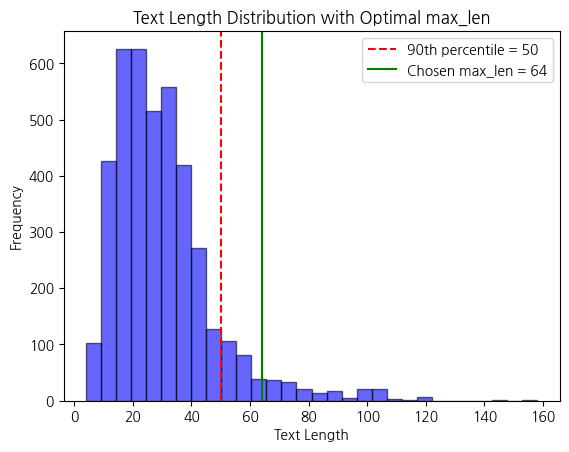

In [16]:
# max_len 길이 구하기
token_lengths = [len(tokenizer.encode(text)) for text in law_train["text"]]

# 최적의 max_len 계산
max_len = calculate_optimal_max_len(token_lengths)

In [17]:
from torch.utils.data import DataLoader, Dataset

# 1. 커스텀 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # `text` 또는 `facts` 열 자동 선택
        self.column_name = 'text' if 'text' in dataframe.columns else 'facts'
        self.texts = self.data[self.column_name]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts.iloc[idx]
    
# 2. 데이터셋 준비
train_dataset = CustomDataset(law_train)
valid_dataset = CustomDataset(law_test)
test_dataset = CustomDataset(lbox_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
# 3. 임베딩 생성 함수
def generate_embeddings(data_loader):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=max_len).to("cuda")
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩 사용
            embeddings.append(cls_embeddings.cpu())
    return torch.cat(embeddings).numpy()

# 데이터 임베딩 생성
train_embeddings = generate_embeddings(train_loader)
valid_embeddings = generate_embeddings(valid_loader)
test_embeddings = generate_embeddings(test_loader)

In [19]:
train_embeddings[:,]

array([[ 0.12480664, -0.6515409 , -0.13723978, ..., -0.15488873,
        -0.13904525,  0.15338817],
       [ 0.17775053, -0.6243988 , -0.1896124 , ..., -0.06340826,
        -0.09460855,  0.13516207],
       [ 0.18604118, -0.6582058 , -0.18260281, ..., -0.09434335,
        -0.10856118,  0.07603566],
       ...,
       [ 0.10944928, -0.6528541 , -0.15339245, ...,  0.00840542,
        -0.16399294,  0.11931564],
       [ 0.04561797, -0.5922253 , -0.19238158, ..., -0.00405112,
        -0.15427777,  0.19347847],
       [ 0.08532043, -0.6910479 , -0.23065807, ..., -0.08147041,
        -0.1294758 ,  0.08173345]], dtype=float32)

## 3. base visualization

### distance

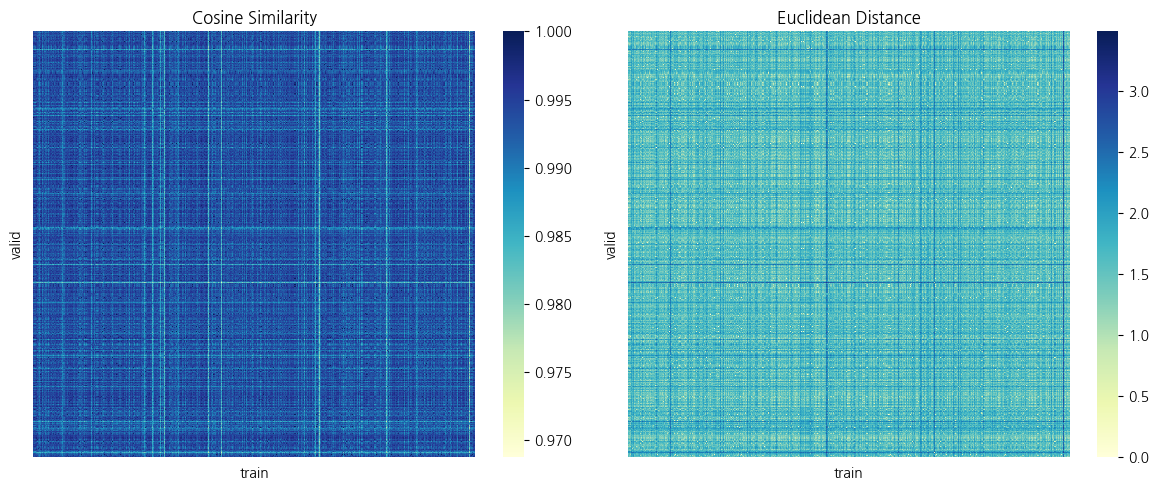

In [20]:
visualize_similarity_distance(train_embeddings, valid_embeddings, 'train', 'valid')

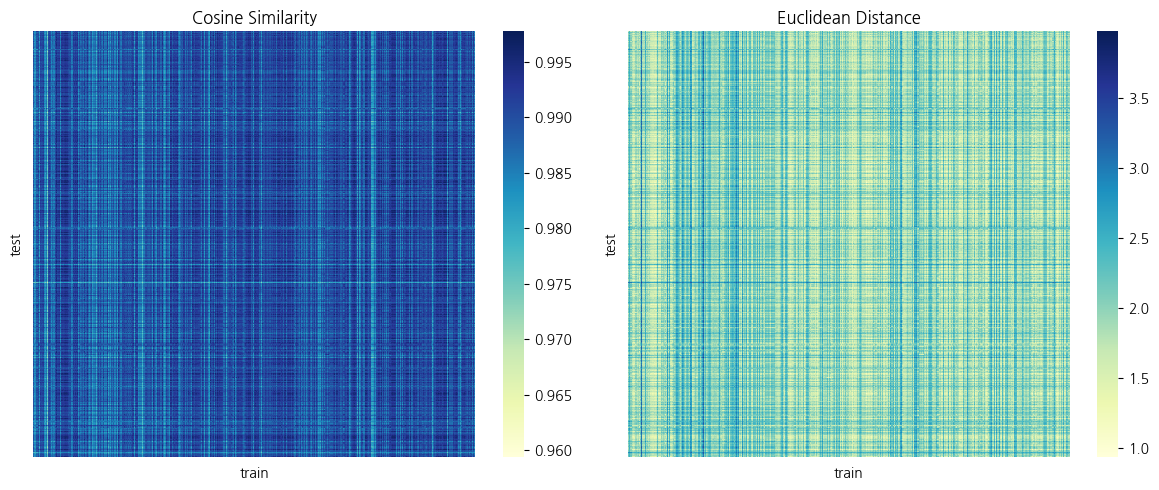

In [21]:
visualize_similarity_distance(train_embeddings, test_embeddings, 'train', 'test')

### plot without dimension reduction

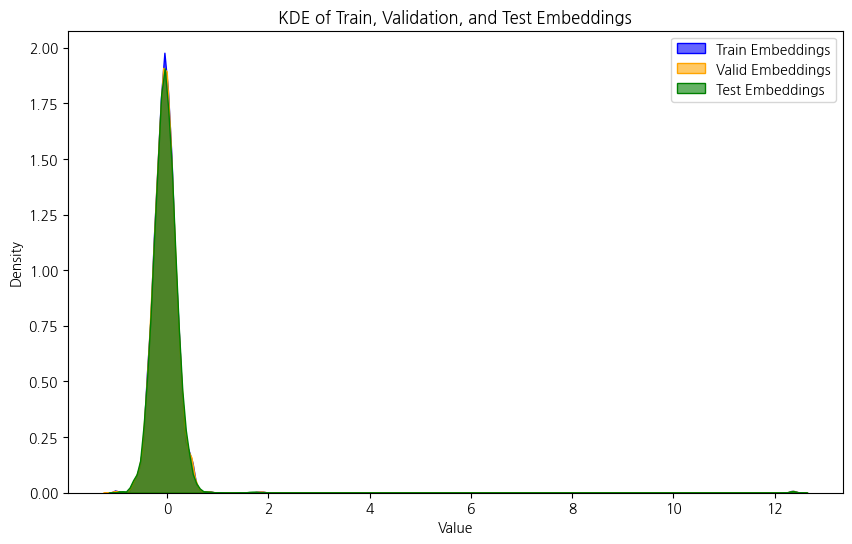

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2D 배열을 1D 배열로 변환
train_embeddings_flat = train_embeddings.flatten()
valid_embeddings_flat = valid_embeddings.flatten()
test_embeddings_flat = test_embeddings.flatten()

# KDE (Kernel Density Estimation) 플롯으로 시각화
plt.figure(figsize=(10, 6))

sns.kdeplot(train_embeddings_flat, shade=True, color='blue', label='Train Embeddings', alpha=0.6)
sns.kdeplot(valid_embeddings_flat, shade=True, color='orange', label='Valid Embeddings', alpha=0.6)
sns.kdeplot(test_embeddings_flat, shade=True, color='green', label='Test Embeddings', alpha=0.6)

# 라벨 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDE of Train, Validation, and Test Embeddings')
plt.legend()

# 시각화 표시
plt.show()
